<a href="https://colab.research.google.com/github/zerocool-11/AI/blob/master/Keras_efficientnet_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [How to do Transfer learning with Efficientnet](https://www.dlology.com/blog/transfer-learning-with-efficientnet/) | DLology

## Imports

In [1]:
# Downgrade pillow to avoid `UserWarning: Possibly corrupt EXIF data.`
!pip install pillow==4.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 99.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pillow: filename=Pillow-4.0.0-cp310-cp310-linux_x86_64.whl size=1083144 sha256=c52a71f319ca77552a84172fc91c14380ce05c539e1c1e7e03fe32193f6d63f1
  Stored in directory: /root/.cache/pip/wheels/84/db/9f/05ee53ecb5fec707ce38b0b1dd115c4165fbf999bda7572063
  Created wheel for olefile: filename=olefile-0.46-py2.py3-none-any.whl size=35417 sha256=8b0ea59a5a5cd4a04b22d32991c2a70a0e2105b86f5a51682fb160563f798286
  Stored in directory: /root/.cache/pip/wheels/02/39/c0/9eb1f7a42b4b38f6f333b6314d4ed11c46f12a0f7b78194f0d
Successfully built pillow olefile
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0
ERROR: pip's dependency resolver does

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir -p dataset/
!unzip /content/drive/MyDrive/undersampled.zip -d ./dataset/

Streaming output truncated to the last 5000 lines.
  inflating: ./dataset/T/16806_DSCF1439_JPG_jpg.rf.87d773318096d7c84928f9a471df009f.jpg  
  inflating: ./dataset/T/49019_DSCF1864_JPG_jpg.rf.64f2f7f38079d232ecedbedfe34e58e5.jpg  
  inflating: ./dataset/T/5931_DSCF3369_JPG_jpg.rf.a992d950b1cb1a549c9bce77e034cedc.jpg  
  inflating: ./dataset/T/26102_IMG_0879_d_2_png_jpg.rf.bd00c3999b3eed30f42de73e235e93d0.jpg  
  inflating: ./dataset/T/87032_DSCF1330_JPG_jpg.rf.c587e353132c3d011d6ea01214fe9af5.jpg  
  inflating: ./dataset/T/20659_DSCF1015_JPG_jpg.rf.c0ba82098fdc7b77fe342a5fbda88e53.jpg  
  inflating: ./dataset/T/54210_DSCF3285_JPG_jpg.rf.2c33fd9a99c3dbedf9e655b37453b1bd.jpg  
  inflating: ./dataset/T/54537_IMG_20211007_160452_jpg.rf.abb29310362069d25f72a5829114c16c.jpg  
  inflating: ./dataset/T/105922_DSCF0941_JPG_jpg.rf.bfefe21ae431d026a1fefcd77fe5029c.jpg  
  inflating: ./dataset/T/118487_left_ocr-81-_jpg.rf.684163e46bf55cb8c44656c37c754a71.jpg  
  inflating: ./dataset/T/127522_ocr_r

In [1]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

## Hyper parameters

In [2]:
batch_size = 48

width = 150
height = 150
epochs = 20
NUM_TRAIN = 2000
NUM_TEST = 1000
dropout_rate = 0.2
input_shape = (height, width, 3)

## Clone **efficientnet** repo

In [3]:
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
  !git clone https://github.com/Tony607/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/content
/content/efficientnet_keras_transfer_learning


## Import efficientnet and load the conv base model

In [11]:
!pip install -U keras

In [7]:
pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-yb5h2bl1
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/efficientnet /tmp/pip-req-build-yb5h2bl1
  Resolved https://github.com/qubvel/efficientnet to commit f7f3e736c113b872caf53dae9fbbda996a8eb87d
  Preparing metadata (setup.py) ... done


In [1]:
import tensorflow as tf

In [4]:
# loading pretrained conv base model
conv_base = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224,224,3))

TypeError: ignored

## Download and extract `dog_vs_cat` dataset

In [ ]:
if not os.path.isfile("kagglecatsanddogs_3367a.zip"):
  !wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
  !unzip -qq kagglecatsanddogs_3367a.zip -d dog_vs_cat
else:
  print("dataset already exist.")

--2019-06-09 01:29:04--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.28.88.168, 2600:1408:8400:3a9::e59, 2600:1408:8400:385::e59
Connecting to download.microsoft.com (download.microsoft.com)|184.28.88.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_3367a.zip’

kagglecatsanddogs_3 100%[===================>] 786.68M   126MB/s    in 5.7s    

2019-06-09 01:29:10 (138 MB/s) - ‘kagglecatsanddogs_3367a.zip’ saved [824894548/824894548]



In [ ]:
!ls dog_vs_cat/PetImages/
!ls dog_vs_cat/PetImages/Cat -l -t | head -10

Cat  Dog
total 408428
-rw-r--r-- 1 root root   34297 Feb 10  2017 9955.jpg
-rw-r--r-- 1 root root   26013 Feb 10  2017 9956.jpg
-rw-r--r-- 1 root root   26293 Feb 10  2017 9957.jpg
-rw-r--r-- 1 root root   36293 Feb 10  2017 9958.jpg
-rw-r--r-- 1 root root   36690 Feb 10  2017 9959.jpg
-rw-r--r-- 1 root root   15262 Feb 10  2017 9960.jpg
-rw-r--r-- 1 root root   49493 Feb 10  2017 9961.jpg
-rw-r--r-- 1 root root   14785 Feb 10  2017 9962.jpg
-rw-r--r-- 1 root root   39717 Feb 10  2017 9963.jpg


In [ ]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = './dog_vs_cat/PetImages'

cat_images = glob.glob(os.path.join(original_dataset_dir, "Cat", '*.jpg'))
dog_images = glob.glob(os.path.join(original_dataset_dir, "Dog", '*.jpg'))
print("total cat images: {}\n\rtotal dog images: {}".format(len(cat_images), len(dog_images)))

total cat images: 12500
total dog images: 12500


In [ ]:


# The directory where we will
# store our smaller dataset
base_dir = './data/dog_vs_cat_small'
os.makedirs(base_dir, exist_ok=True)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.makedirs(train_cats_dir, exist_ok=True)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.makedirs(train_dogs_dir, exist_ok=True)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.makedirs(validation_cats_dir, exist_ok=True)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.makedirs(validation_dogs_dir, exist_ok=True)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
os.makedirs(test_cats_dir, exist_ok=True)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.makedirs(test_dogs_dir, exist_ok=True)

# Copy first NUM_TRAIN//2 cat images to train_cats_dir
fnames = cat_images[:NUM_TRAIN//2]
for fname in fnames:
    dst = os.path.join(train_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

offset = NUM_TRAIN//2
# Copy next NUM_TEST //2 cat images to validation_cats_dir
fnames = cat_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(validation_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
offset = offset + NUM_TEST // 2
# Copy next NUM_TRAIN//2 cat images to test_cats_dir
fnames = cat_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(test_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


# Copy first NUM_TRAIN//2 dog images to train_dogs_dir
fnames = dog_images[:NUM_TRAIN//2]
for fname in fnames:
    dst = os.path.join(train_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

offset = NUM_TRAIN//2
# Copy next NUM_TEST // 2 dog images to validation_dogs_dir
fnames = dog_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(validation_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
offset = offset + NUM_TEST // 2

# Copy next NUM_TEST // 2 dog images to test_dogs_dir
fnames = dog_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(test_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to target height and width.
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
conv_base = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224,224,3))
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(2, activation='softmax', name="fc_out"))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 5, 5, 1280)        4049564   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1280)              0         
_________________________________________________________________
fc_out (Dense)               (None, 2)                 2562      
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [ ]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 213
This is the number of trainable layers after freezing the conv base: 2


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

Epoch 1/20
42/42 [==============================] - 19s 443ms/step - loss: 1.8058 - acc: 0.5170 - val_loss: 1.6408 - val_acc: 0.4720
Epoch 2/20
42/42 [==============================] - 17s 394ms/step - loss: 1.8047 - acc: 0.5245 - val_loss: 1.5966 - val_acc: 0.4960
Epoch 3/20
42/42 [==============================] - 16s 388ms/step - loss: 1.8297 - acc: 0.5210 - val_loss: 1.5447 - val_acc: 0.5050
Epoch 4/20
42/42 [==============================] - 16s 388ms/step - loss: 1.6701 - acc: 0.5405 - val_loss: 1.4762 - val_acc: 0.5260
Epoch 5/20
42/42 [==============================] - 17s 400ms/step - loss: 1.6825 - acc: 0.5390 - val_loss: 1.4191 - val_acc: 0.5370
Epoch 6/20
42/42 [==============================] - 16s 391ms/step - loss: 1.5552 - acc: 0.5655 - val_loss: 1.3300 - val_acc: 0.5660
Epoch 7/20
42/42 [==============================] - 16s 390ms/step - loss: 1.6115 - acc: 0.5635 - val_loss: 1.2348 - val_acc: 0.5770
Epoch 8/20
42/42 [==============================] - 16s 391ms/step - 

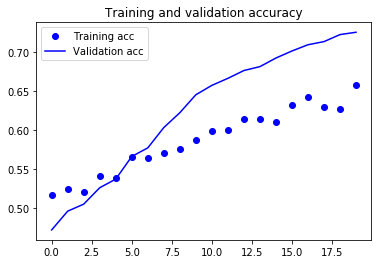

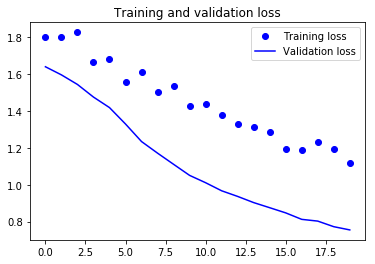

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Fine tuning last several layers.

In [ ]:
# multiply_16
# set 'multiply_16' and following layers trainable
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'multiply_16':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

Epoch 1/20
42/42 [==============================] - 18s 424ms/step - loss: 1.1131 - acc: 0.6610 - val_loss: 0.7262 - val_acc: 0.7360
Epoch 2/20
42/42 [==============================] - 16s 377ms/step - loss: 1.1714 - acc: 0.6570 - val_loss: 0.7053 - val_acc: 0.7420
Epoch 3/20
42/42 [==============================] - 16s 380ms/step - loss: 1.0955 - acc: 0.6690 - val_loss: 0.6855 - val_acc: 0.7520
Epoch 4/20
42/42 [==============================] - 16s 377ms/step - loss: 1.0311 - acc: 0.6660 - val_loss: 0.6783 - val_acc: 0.7530
Epoch 5/20
42/42 [==============================] - 16s 374ms/step - loss: 1.0248 - acc: 0.6850 - val_loss: 0.6653 - val_acc: 0.7590
Epoch 6/20
42/42 [==============================] - 16s 374ms/step - loss: 0.9756 - acc: 0.6945 - val_loss: 0.6460 - val_acc: 0.7650
Epoch 7/20
42/42 [==============================] - 16s 374ms/step - loss: 1.0248 - acc: 0.6880 - val_loss: 0.6377 - val_acc: 0.7700
Epoch 8/20
42/42 [==============================] - 16s 376ms/step - 

In [ ]:
os.makedirs("./models", exist_ok=True)
model.save('./models/cats_and_dogs_small.h5')

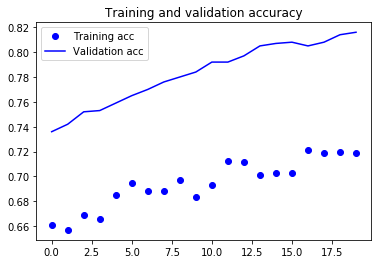

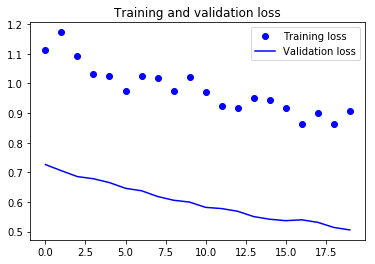

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Test predict

In [ ]:
cat_img = cat_images[-1]
dog_img= dog_images[-1]

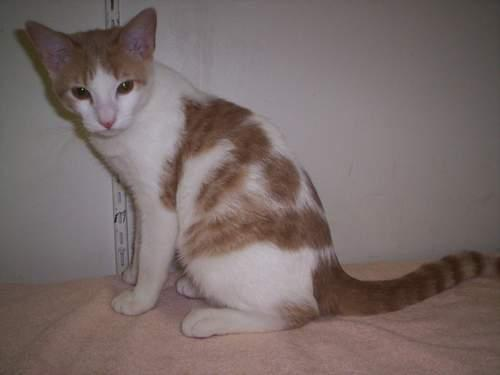

In [ ]:
Image(filename=cat_img)

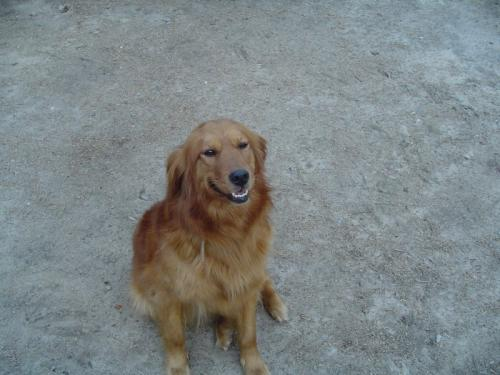

In [ ]:
Image(filename=dog_img)

In [ ]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])[0][0]
    if result > 0.5:
        animal = "cat"
    else:
        animal = "dog"
        result = 1 - result
    return animal,result

print(predict_image(cat_img))
print(predict_image(dog_img))

('cat', 0.9974619)
('dog', 0.9999910624692347)


## Download the model

In [ ]:
from google.colab import files

files.download('./models/cats_and_dogs_small.h5')

In [ ]:
model.input_shape

(None, 150, 150, 3)

## Load the model

In [ ]:
from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("./models/cats_and_dogs_small.h5")